In [1]:
import duckdb, joblib, optuna, os, shap
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from lightgbm import early_stopping, log_evaluation
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    brier_score_loss,
    log_loss,
)
from sklearn.model_selection import train_test_split

import repl_utils, stats_utils, data_utils, ml_utils, plot_utils
from variables import Variables as vars

pd.options.mode.copy_on_write = True

plt.style.use("../../notebook.mplstyle")

os.makedirs("./output", exist_ok=True)

RANDOM_SEED = repl_utils.RANDOM_SEED
np.random.seed(RANDOM_SEED)
rng = np.random.default_rng(RANDOM_SEED)

N_CORES = joblib.cpu_count(only_physical_cores=True)

START_TIME = datetime.now()

OUTPUT_DIR = f"output/0002-predictors/{START_TIME:%Y%m%d-%H%M%S}"

os.makedirs(OUTPUT_DIR, exist_ok=True)

repl_utils.print_environment_info()

print(f"\n--------------------\nOutput directory: {OUTPUT_DIR}\n--------------------\n")

-------------------- Environment Information --------------------
date: 2025-12-24T10:18:24.830541
platform: Windows-11-10.0.26220-SP0
platform_version: 10.0.26220
cpu: Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
cores: 32
physical_cores: 24
ram: 127 GB
ram_available: 98 GB
cuda: True
cuda_device_count: 1
cuda_device_0: NVIDIA GeForce RTX 4070 Ti SUPER
python: 3.13.11 | packaged by conda-forge | (main, Dec  6 2025, 11:10:00) [MSC v.1944 64 bit (AMD64)]
numpy: 2.3.5
pandas: 2.3.3
scipy: 1.16.3
sklearn: 1.8.0
pytorch: 2.9.1
pymc: 5.27.0
pytensor: 2.36.1
arviz: 0.23.0

--------------------
Output directory: output/0002-predictors/20251224-101824
--------------------



In [2]:
numeric = [
    vars.YEAR,
    vars.DBWT,
    vars.PWGT_R,
    vars.WTGAIN,
    vars.BMI,
    vars.MAGE_C,
    vars.FAGECOMB,
]

categorical = [
    vars.DOB_MM,
    vars.DOB_WK,
    "dob_tt_pm",
    vars.BFACIL3,
    vars.SEX,
    vars.PRECARE,
    vars.GESTREC10,
    vars.RF_PDIAB,
    vars.RF_GDIAB,
    vars.RF_PHYPE,
    vars.RF_GHYPE,
    vars.RF_EHYPE,
    vars.RF_PPTERM,
    vars.RF_INFTR,
    vars.RF_FEDRG,
    vars.RF_ARTEC,
    vars.NO_RISKS,
    vars.LD_INDL,
    vars.LD_AUGM,
    vars.ME_PRES,
    vars.DMETH_REC,
    vars.APGAR5,
    vars.APGAR10,
    vars.AB_AVEN1,
    vars.AB_AVEN6,
    vars.AB_NICU,
    vars.AB_SURF,
    vars.AB_ANTI,
    vars.AB_SEIZ,
    vars.NO_ABNORM,
    vars.CA_ANEN,
    vars.CA_MNSB,
    vars.CA_CCHD,
    vars.CA_CDH,
    vars.CA_OMPH,
    vars.CA_GAST,
    vars.CA_LIMB,
    vars.CA_CLEFT,
    vars.CA_CLPAL,
    vars.CA_HYPO,
    vars.CA_DISOR,
    vars.NO_CONGEN,
    vars.MEDUC,
    vars.MRACEHISP,
    vars.FEDUC,
    vars.FRACEHISP,
    vars.PAY_REC,
    vars.WIC,
]

features = categorical + numeric

In [ ]:
df = data_utils.load_predictors_data(from_year=2005, include_unknown=True)
df[categorical] = df[categorical].astype("category")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [4]:
X = df[features]
y = df["ca_down_c_p_n"]

X[categorical] = X[categorical].astype("category")

In [5]:
gbm = lgb.Booster(model_file="output/0002-predictors/20251223-101917/final_model_2.txt")
calibrator = joblib.load("output/0002-predictors/20251223-101917/final_calibrator.joblib")
meta = joblib.load("output/0002-predictors/20251223-101917/final_model_meta.joblib")
best_iter = meta["best_iteration"] or None

def predict_calibrated_proba(gbm, calibrator, X, best_iter=None):
    s = gbm.predict(X, num_iteration=best_iter, raw_score=True)
    return calibrator.predict_proba(s.reshape(-1, 1))[:, 1]

# Ensure column order matches training
X_full = X[meta["features"]]

p_new = predict_calibrated_proba(gbm, calibrator, X_full, best_iter=best_iter)

In [6]:
df["p_ds_lb_pred_01"] = p_new

In [8]:
df[["year", "p_ds_lb_pred_01"]].groupby("year").sum().reset_index()

,year,p_ds_lb_pred_01
0,2005,1923.803925
1,2006,1936.961313
2,2007,1953.200590
3,2008,1955.882062
4,2009,1791.360576
5,2010,1792.455967
6,2011,1777.799937
7,2012,1823.728971
8,2013,1845.264094
9,2014,1981.495157


In [9]:
import duckdb
con = duckdb.connect("./data/us_births.db")

In [18]:
con.execute(
    """
    ALTER TABLE us_births ADD COLUMN IF NOT EXISTS p_ds_lb_pred_01 DOUBLE;
    """
)
con.execute("DROP TABLE IF EXISTS ds_lb_pred_01")
con.execute(f"CREATE TABLE ds_lb_pred_01 (id BIGINT, p_ds_lb_pred DOUBLE)")

In [22]:
prob_results = df[["id", "p_ds_lb_pred_01"]]

con.execute(
    """
    INSERT INTO ds_lb_pred_01 (id, p_ds_lb_pred)
    SELECT id, p_ds_lb_pred_01
    FROM prob_results
    """
)

In [23]:
imported = con.execute(
    """    
    SELECT *
    FROM ds_lb_pred_01
    """
).df()
imported

,id,p_ds_lb_pred
0,66719046,7.537461e-04
1,66718392,3.382834e-04
2,66713867,9.772956e-05
3,66713873,1.410636e-04
4,66698417,9.117495e-04
...,...,...
78161813,142682231,2.807930e-07
78161814,142682726,2.861069e-07
78161815,142678072,2.782279e-07
78161816,142679094,2.773348e-07


In [24]:
con.execute(
    """
    UPDATE us_births b
    SET p_ds_lb_pred_01 = p.p_ds_lb_pred
    FROM ds_lb_pred_01 p
    WHERE b.id = p.id;
    """
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [17]:
con.execute("DROP TABLE IF EXISTS ds_lb_pred_01")

In [ ]:
con = duckdb.connect("./data/us_births.db")

In [30]:
df = con.execute(
    """
    SELECT
        b.year,
        ca_down_c,
        count(*) as n_births,
        SUM(b.p_ds_lb_pred_01) as predicted
    FROM us_births b
    WHERE b.year >= 2005
    GROUP BY b.year, ca_down_c
    ORDER BY b.year, ca_down_c;
    """
).df()
df

,year,ca_down_c,n_births,predicted
0,2005,C,1513,8.305480
1,2005,N,4093941,1904.497474
2,2005,P,494,11.000971
3,2005,U,49666,NaN
4,2006,C,1393,6.273818
...,...,...,...,...
75,2023,U,8333,NaN
76,2024,C,864,758.439271
77,2024,N,3626913,242.441769
78,2024,P,1022,896.392963


In [38]:
df = con.execute(
    """
    SELECT
        ca_down_c,
        count(*) as n_births,
        SUM(b.p_ds_lb_pred_01) as predicted,
        SUM(b.p_ds_lb_pred_01) / count(*) as predicted_rate
    FROM us_births b
    WHERE b.year >= 2020
    GROUP BY ca_down_c
    ORDER BY ca_down_c;
    """
).df()
df

,ca_down_c,n_births,predicted,predicted_rate
0,C,4300,3718.790389,0.864835
1,N,18161657,1231.502212,0.000068
2,P,5159,4503.880622,0.873014
3,U,38184,NaN,NaN


In [41]:
df = con.execute(
    """
    SELECT
        year,
        AVG(CASE WHEN no_congen IS NULL THEN 1 ELSE 0 END) AS no_congen,
        AVG(CASE WHEN ab_nicu IS NULL THEN 1 ELSE 0 END) AS ab_nicu,
        AVG(CASE WHEN dbwt IS NULL THEN 1 ELSE 0 END) AS dbwt
    FROM us_births
    WHERE year >= 2005
    GROUP BY year
    ORDER BY year;
    """
).df()
df

,year,no_congen,ab_nicu,dbwt
0,2005,1.000000,0.692442,0.0
1,2006,1.000000,0.513213,0.0
2,2007,1.000000,0.447680,0.0
3,2008,1.000000,0.351051,0.0
4,2009,1.000000,0.319277,0.0
5,2010,1.000000,0.226115,0.0
6,2011,1.000000,0.142060,0.0
7,2012,1.000000,0.117422,0.0
8,2013,1.000000,0.095501,0.0
9,2014,0.038602,0.035741,0.0


Text(0.5, 1.0, 'Proportion of missing no_congen values')

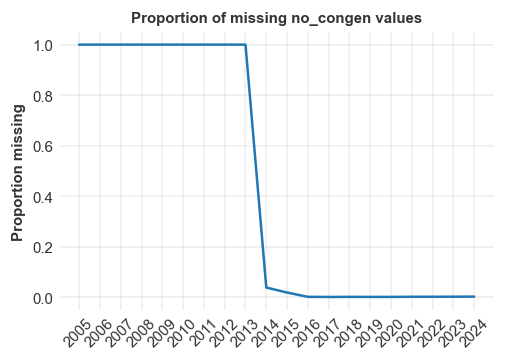

In [45]:
plt.plot(df["year"], df["no_congen"], label="no_congen missing")
plt.xticks(df["year"], rotation=45)
plt.ylabel("Proportion missing")
plt.title("Proportion of missing no_congen values")

In [39]:
df = con.execute(
    """
    SELECT
        ca_down_c,
        count(*) as n_births,
        SUM(b.p_ds_lb_pred_01) as predicted,
        SUM(b.p_ds_lb_pred_01) / count(*) as predicted_rate
    FROM us_births b
    WHERE b.year >= 2005 AND b.year < 2010
    GROUP BY ca_down_c
    ORDER BY ca_down_c;
    """
).df()
df

,ca_down_c,n_births,predicted,predicted_rate
0,C,6400,39.693938,0.006202
1,N,20882962,9442.323328,0.000452
2,P,3760,79.191200,0.021061
3,U,242717,NaN,NaN


In [18]:
con.close()